In [11]:
import mne
from mne.preprocessing import ICA  # Import it explicitly to minimize required code and refer to it more easily

plot = False

## Definitions:

# Define eeg channels for when we need to pass them explicitly as arguments
eeg_channels = ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']
eog_channels=['Fp1', 'Fp2']


### Syntax: mne.io.read_raw_edf(r'file', eog=[list of eog channels], preload=True, speed things up, infer_types=True, discover channel types) 
#raw = mne.io.read_raw_edf(r'EDF+\103918\103918.edf', eog=['Fp1', 'Fp2'], preload=True, infer_types=True) ##NOTE: YOU MUST watch the capitalization!
raw = mne.io.read_raw_edf(
    r'EDF+\103918\103918.edf',
    #eog=['Fp1', 'Fp2'], # Define eog channels!  I suggest trying making a copy of these as eog1 and eog2 ##NOTE: YOU MUST watch the capitalization!
    misc=None, # List of channel names to be considered as miscellaneous (MISC) channels.
    stim_channel=None,  # Set to None if you don't have a stim channel
    exclude=[],  # Exclude channels you don't want
    preload=True,  # Preload data into memory to speed things up
    infer_types=True,  # Infer channel types from names
    verbose=True  # Set verbosity / output messages
    )

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')
raw.pick('eeg') # Pick only eeg related data!  However, we still have more data then we need!  We'll plot only the channels we want
# raw.plot(picks=eeg_channels, block=False) #Block must be True if working interactively with a .py file.  Also, we are picking only eeg channels

print('Lets compare with and without dc removed:')
if plot:
    raw.pick('eeg').plot(picks=eeg_channels, title = 'Raw Data',block=False, remove_dc=False) # Pick only eeg related data!  However, we still have more data then we need!  We'll plot only the channels we want
    print('DC removed:')
    print('Notice that removing the DC drifts\n makes more data fit on the graph!\n\n')
if plot:
    raw.pick('eeg').plot(picks=eeg_channels, title = 'Raw Data',block=False) # Pick only eeg related data!  However, we still have more data then we need!  We'll plot only the channels we want
    print("Let's filter the raw so that we can see how much it improves the signal!")
filtered = raw.copy().filter(l_freq=1, h_freq=40)
# filtered.pick('eeg') # Pick only eeg related data!  However, we still have more data then we need!  We'll plot only the channels we want
if plot:
    filtered.pick('eeg').plot(picks=eeg_channels, title = 'Filtered Data',block=False) # Pick only eeg related data!  However, we still have more data then we need!  We'll plot only the channels we want
ica = ICA(n_components=32, random_state=97, max_iter="auto")
ica.fit(filtered)


# Find EOG and muscle artifacts
eog_indices, eog_scores = ica.find_bads_eog(filtered, ch_name=['Fp1','Fp2'])
muscle_noise_indices, muscle_noise_scores = ica.find_bads_muscle(filtered)

# Exclude the identified artifact components
ica.exclude = list(set(eog_indices + muscle_noise_indices))

# Apply ICA to the raw data
filtered_clean = ica.apply(filtered.copy())
# raw #Block must be True if working interactively with a .py file.  Also, we are picking only eeg channels
if plot:
    filtered_clean.pick('eeg').plot(picks=eeg_channels, title = 'Filtered Data',block=False)
    
pdf_value = filtered_clean.compute_psd(
    method = 'multitaper',
    fmin = 1,
    fmax = 40,
    tmin = 0,
    tmax = 60,
    picks = 'eeg',
    proj = False
)
df = pdf_value.to_data_frame(picks = eeg_channels)

brain_waves = {
    'Delta': (0.1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta Low': (13, 20),
    'Beta High': (20, 30),
    'Gamma': (30, 40)
}

brain_wave_rows = {
    'Delta': (None, None),
    'Theta': (None, None),
    'Alpha': (None, None),
    'Beta Low': (None, None),
    'Beta High': (None, None),
    'Gamma': (None, None)
}

# Populate brain_wave_rows with filtered DataFrame rows
for wave, (min_freq, max_freq) in brain_waves.items():
    filtered_rows = df[(df['freq'] >= min_freq) & (df['freq'] <= max_freq)]
    brain_wave_rows[wave] = filtered_rows
    # print(filtered_rows)

# Initialize a dictionary to hold the statistics
brain_wave_statistics = {wave: {} for wave in brain_waves}

# # Print the brain_wave_rows to verify
# for wave, rows in brain_wave_rows.items():
#     print(f'{wave}:\n{rows}\n')

for wave in brain_waves:
    print(wave)
    # print(brain_waves[wave])
    min, max = brain_waves[wave]
    print(f'Min:{min}, Max:{max}')
    
    # for row in df.loc[1:, 'freq']:
    #     print(row)
        
for wave, rows in brain_wave_rows.items():
    min,max = brain_waves[wave]
    print(f'{wave}, min:{min}, max:{max}:\n{rows}\n')
    

Extracting EDF parameters from f:\WEBSITE\EDF_analysis\EDF+\103918\103918.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 143999  =      0.000 ...  1124.992 secs...
Lets compare with and without dc removed:
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Fitting ICA to data using 127 channels (please be patient, this may take a while)
Selecting by number: 32 components


C:\Users\Admin\AppData\Local\Temp\ipykernel_14156\2726833113.py:44: RuntimeWarning: Using n_components=32 (resulting in n_components_=32) may lead to an unstable mixing matrix estimation because the ratio between the largest (1.2e+02) and smallest (2.8e-07) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 10
  ica.fit(filtered)


Fitting ICA took 12.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 16.000 (s)
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 1 ICA component
    Projecting back using 127 PCA components
    Using multitaper spectrum estimation with 7 DPSS windows
Delta
Min:0.1, Max:4
Theta
Min:4, Max:8
Alpha
Min:8, Max:13
Beta Low
Min:13, Max:20
Beta High
Min:20, Max:30
Gamma
Min:30, Max:40
Delta, min:0.1, max:4:
         freq            Cz            Fz           Fp1            F7  \
0    1.016534  5.389264e-08  4.875588e-08  1.215555e-07  2.362310e-08   
1    1.033199  4.296519e-08  4.431296e-08  1.453851e-07  2.937635e-08   
2    1.049863  4.364024e-08  4.026233e-08  1.416509e-07  2.654880e-08   
3    1.066528  4.904989e-08  4.381069e-08  1.176171e-07  1.929772e-08   
4    1.083192  3.768185e-08  3.552461e-08  1.083914e-07  2.212681e-08   
..        ...           ...           ...           ...           ...   
175  3.932821  1.485336e-09  1.803892e-09  3.295361e-08  5.355149e-09   
176  3.949486  

In [6]:
# Calculate statistics for each brain wave per electrode location
for wave, rows in brain_wave_rows.items():
    for col in rows.columns:
        if col != 'freq':
            desc = rows[col].describe(percentiles=[.25, .5, .75])
            median = rows[col].median()
            mode = rows[col].mode().values
            brain_wave_statistics[wave][col] = {
                'count': desc['count'],
                'mean': desc['mean'],
                'std': desc['std'],
                'min': desc['min'],
                '25%': desc['25%'],
                '50%': median,  # Using median for 50%
                '75%': desc['75%'],
                'max': desc['max'],

            }

# Print the statistics to verify
for wave, stats in brain_wave_statistics.items():
    print(f'{wave} statistics:')
    for electrode, stat in stats.items():
        print(f'  {electrode}:')
        for key, value in stat.items():
            print(f'    {key}: {value}')

Delta statistics:
  Cz:
    count: 180.0
    mean: 8.044898272849247e-09
    std: 1.1128582427803885e-08
    min: 7.901148615250792e-10
    25%: 2.2470041197409183e-09
    50%: 3.741749896998146e-09
    75%: 7.139342324555908e-09
    max: 5.5871561431783675e-08
  Fz:
    count: 180.0
    mean: 7.282891258780383e-09
    std: 9.411119447993333e-09
    min: 9.315023787878936e-10
    25%: 2.3970755980905727e-09
    50%: 3.54364015084205e-09
    75%: 7.4423360112695775e-09
    max: 4.875587951466693e-08
  Fp1:
    count: 180.0
    mean: 5.7529692040348104e-08
    std: 3.59314711407253e-08
    min: 1.1294941181404206e-08
    25%: 3.23023930345147e-08
    50%: 4.877995995794981e-08
    75%: 7.082052554598377e-08
    max: 1.7509578750995363e-07
  F7:
    count: 180.0
    mean: 8.731873116232593e-09
    std: 6.102903023648571e-09
    min: 1.7710375988359933e-09
    25%: 4.168228972955129e-09
    50%: 6.375221550290011e-09
    75%: 1.127297406347366e-08
    max: 2.9376348703928302e-08
  F3:
    

In [7]:
# Brain waves and their frequency ranges
brain_waves = {
    'Delta': (0.1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta Low': (13, 20),
    'Beta High': (20, 30),
    'Gamma': (30, 40)
}

# Define the electrode locations by brain lobes
brain_lobes = {
    'Frontal': ['Fz', 'Fp1', 'F7', 'F3', 'FC1', 'Fp2', 'FC2', 'F4', 'F8'],
    'Temporal': ['FT9', 'T7', 'FT10', 'T8'],
    'Parietal': ['Cz', 'C3', 'CP5', 'CP1', 'P3', 'P7', 'Pz', 'P4', 'CP2', 'CP6'],
    'Occipital': ['PO9', 'O1', 'Oz', 'O2', 'PO10']
}

# Initialize brain_wave_rows for brain lobes
brain_wave_lobes = {lobe: {wave: None for wave in brain_waves} for lobe in brain_lobes}

# Populate brain_wave_lobes with filtered DataFrame rows for each lobe and wave
for lobe, electrodes in brain_lobes.items():
    for wave, (min_freq, max_freq) in brain_waves.items():
        filtered_rows = df[(df['freq'] >= min_freq) & (df['freq'] <= max_freq)][electrodes]
        brain_wave_lobes[lobe][wave] = filtered_rows

# Initialize a dictionary to hold the statistics
brain_wave_lobes_statistics = {lobe: {wave: {} for wave in brain_waves} for lobe in brain_lobes}

# Calculate statistics for each brain wave per electrode location within each lobe
for lobe, waves in brain_wave_lobes.items():
    for wave, rows in waves.items():
        for col in rows.columns:
            desc = rows[col].describe(percentiles=[.25, .5, .75])
            median = rows[col].median()
            brain_wave_lobes_statistics[lobe][wave][col] = {
                'count': desc['count'],
                'mean': desc['mean'],
                'std': desc['std'],
                'min': desc['min'],
                '25%': desc['25%'],
                '50%': median,  # Using median for 50%
                '75%': desc['75%'],
                'max': desc['max'],
            }

# Print the statistics for each lobe and wave to verify
for lobe, waves in brain_wave_lobes_statistics.items():
    print(f'{lobe} statistics:')
    for wave, stats in waves.items():
        print(f'  {wave}:')
        for electrode, stat in stats.items():
            print(f'    {electrode}:')
            for key, value in stat.items():
                print(f'      {key}: {value}')

Frontal statistics:
  Delta:
    Fz:
      count: 180.0
      mean: 7.282891258780383e-09
      std: 9.411119447993333e-09
      min: 9.315023787878936e-10
      25%: 2.3970755980905727e-09
      50%: 3.54364015084205e-09
      75%: 7.4423360112695775e-09
      max: 4.875587951466693e-08
    Fp1:
      count: 180.0
      mean: 5.7529692040348104e-08
      std: 3.59314711407253e-08
      min: 1.1294941181404206e-08
      25%: 3.23023930345147e-08
      50%: 4.877995995794981e-08
      75%: 7.082052554598377e-08
      max: 1.7509578750995363e-07
    F7:
      count: 180.0
      mean: 8.731873116232593e-09
      std: 6.102903023648571e-09
      min: 1.7710375988359933e-09
      25%: 4.168228972955129e-09
      50%: 6.375221550290011e-09
      75%: 1.127297406347366e-08
      max: 2.9376348703928302e-08
    F3:
      count: 180.0
      mean: 1.2980753427354917e-08
      std: 8.531348226084491e-09
      min: 2.4051685957806897e-09
      25%: 7.114144240079732e-09
      50%: 1.10066576044217

In [8]:
# Initialize a dictionary to hold the average statistics
brain_wave_lobes_avg = {lobe: {wave: None for wave in brain_waves} for lobe in brain_lobes}

# Calculate average across all electrodes within each brain lobe for each brain wave
for lobe, electrodes in brain_lobes.items():
    for wave, (min_freq, max_freq) in brain_waves.items():
        filtered_rows = df[(df['freq'] >= min_freq) & (df['freq'] <= max_freq)][electrodes]
        avg_across_electrodes = filtered_rows.mean(axis=1)  # Calculate mean across electrodes
        brain_wave_lobes_avg[lobe][wave] = avg_across_electrodes.mean()  # Mean of means across frequencies

# Print the averages for each lobe and wave to verify
for lobe, waves in brain_wave_lobes_avg.items():
    print(f'{lobe} average statistics:')
    for wave, value in waves.items():
        print(f'  {wave}: {value}')

Frontal average statistics:
  Delta: 1.9377692466739004e-08
  Theta: 3.0504491756673847e-09
  Alpha: 8.591480690621809e-10
  Beta Low: 2.892713047436671e-10
  Beta High: 1.8447458359968304e-10
  Gamma: 1.3631765511856587e-10
Temporal average statistics:
  Delta: 8.905871273971451e-09
  Theta: 1.2602008980627026e-09
  Alpha: 4.178838642202124e-10
  Beta Low: 4.459477348115114e-10
  Beta High: 6.679553332844747e-10
  Gamma: 5.927803219432317e-10
Parietal average statistics:
  Delta: 9.149555589729758e-09
  Theta: 1.8924845896083825e-09
  Alpha: 5.848144308244975e-10
  Beta Low: 2.0509460718110377e-10
  Beta High: 1.4070620064699793e-10
  Gamma: 1.088407070366334e-10
Occipital average statistics:
  Delta: 6.013009241433383e-09
  Theta: 9.881289789513351e-10
  Alpha: 2.847884659320078e-10
  Beta Low: 1.4679907987726448e-10
  Beta High: 1.4274964466933643e-10
  Gamma: 1.272990840321819e-10


Effective window size : 16.000 (s)


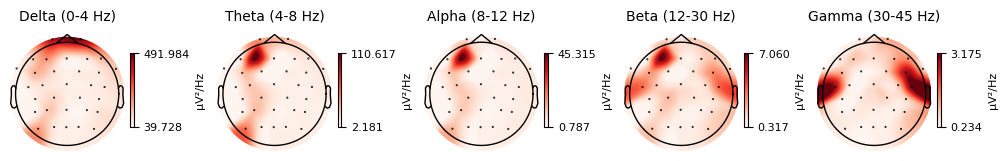

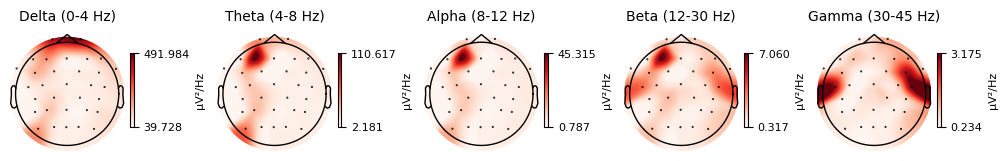

In [9]:
filtered_clean.pick(eeg_channels).compute_psd().plot_topomap(
    ch_type="eeg", 
    normalize=False, 
    contours=0
    )

Effective window size : 16.000 (s)


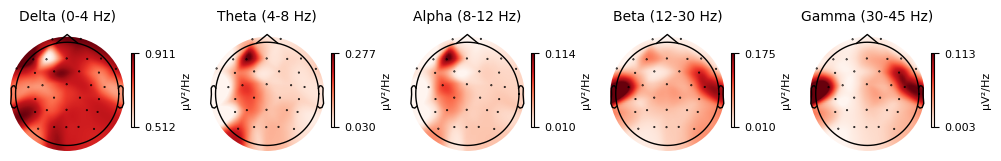

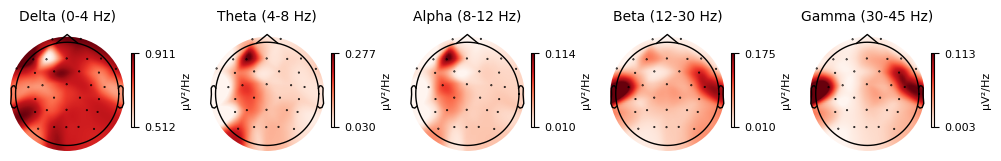

In [12]:
filtered_clean.pick(eeg_channels).compute_psd().plot_topomap(
    ch_type="eeg", 
    normalize=True, 
    contours=0
    )

Effective window size : 16.000 (s)


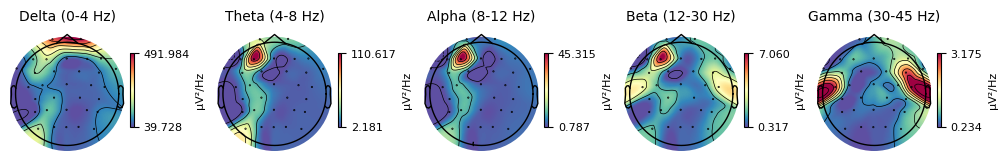

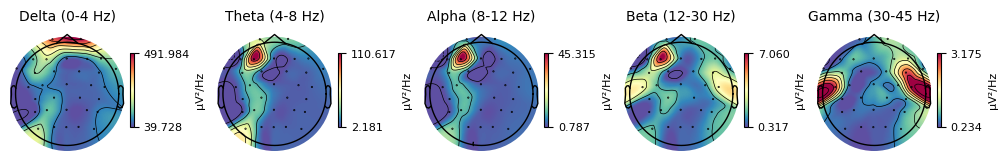

In [10]:
filtered_clean.pick(eeg_channels).compute_psd().plot_topomap(
    ch_type="eeg",
    normalize=False, 
    sensors=True, 
    # names=None, 
    mask=None, 
    mask_params=None, 
    contours=8, 
    outlines='head', 
    sphere=None, 
    image_interp='cubic', 
    extrapolate='auto', 
    border='mean', 
    res=64, 
    size=1, 
    # cmap='RdBu_r', 
    # cmap='viridis', 
    # cmap='plasma', 
    # cmap='inferno', 
    # cmap='magma', 
    # cmap='cividis', 
    cmap='Spectral_r', 
    vlim=(None, None), 
    cnorm=None, 
    axes=None, 
    show=True, 
    )